# TP Analyse scenarios IMACLIM-R - 26/10/23

Pré-requis: 
- un environnement python avec les modules demandés installés, la possibilité de travailler avec des notebook (par exemple Jupyter Lab https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html, conseil : https://github.com/lckr/jupyterlab-variableInspector pour visualiser les variables)
- le dossier data (qui contient les données) dans le répertoire de travail


Vous allez analyser des résultats de scénarios issus du modèle Imaclim-R monde (https://www.iamcdocumentation.eu/Model_Documentation_-_IMACLIM.)


Le document « ensemble scenarios ImaclimR.pdf » décrit comment un ensemble de scénarios de « baseline », i.e. sans politique climatique, a été obtenu. La base de données de scénarios est enrichie de scénarios « d’atténuation », i.e. avec un objectif de réduction des émissions de gaz à effet de serre ; un scénario d’atténuation par baseline.
Les résultats correspondants à l’ensemble de ces scénarios en termes d’émissions de $CO_2$ (ECO2_w.csv), de PIB (GDP_w.csv) et de PIB par habitant (GDPcap_w.csv), d’intensité énergétique du PIB (EI_w.csv) et d’intensité carbone de l’énergie (CI_w.csv), à l’échelle mondiale sur la période 2015-2065, sont fournis dans le dossier /data.

Ce dossier contient également les trajectoires de population mondiale, exogène, de l’ensemble des scénarios (Pop_w.csv). Tous les résultats sont donnés en indice par rapport à la valeur 2015. La première ligne donne les années dans les fichiers de résultats. Chaque ligne suivante correspond à un scenario de la base de données de scénarios. Par ailleurs, le dossier contient également un fichier drivers.csv qui donne la combinaison des groupes de paramètres correspondant à chaque scénario (voir le fichier readme.txt pour une explication des indices du fichier drivers.csv). Dans tous les fichiers csv les scénarios sont classés dans le même ordre. 


Commencez par lire les différents documents, et par ouvrir les fichiers csv pour comprendre comment les données sont organisées.


Vous allez créer et utiliser un code python3 pour lire les données de résultats, et les analyser en traçant un certain nombre de graphiques. Le rendu du TP sera à la fois le code lui-même, et ce fichier dans lequel vous aurez copié vos graphiques et rédigé vos analyses. Vous êtes cependant libre sur le format final du rendu (codé commenté + document word/pdf, notebook...).


In [42]:

import csv
import os #lecture ecriture de csv; os management
import numpy as np #traitement de matrice de type numpy array
import matplotlib.pyplot as plt #librairy graphique
#ANOVA: fin du TD (optionnel)
from pandas import DataFrame,read_csv,concat,notnull
import glob
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import linregress


# Présentation du modèle Imaclim-R et méthodologie de construction des scénarios

Le modèle **Imaclim-R** est un modèle multi-régional et multi-sectoriel de l’économie mondiale, conçu pour simuler les trajectoires économiques et énergétiques à l’échelle mondiale. Sa structure hybride et dynamique combine un cadre d’équilibre général calculable (CGE) avec des modules sectoriels, permettant de capturer les interactions complexes entre la macroéconomie, l’énergie et les dynamiques sectorielles. Le modèle prend en compte des imperfections de marché, une utilisation partielle des facteurs de production et des anticipations imparfaites, ce qui le distingue des modèles plus simplifiés. 

Les données utilisées sont calibrées sur l’année de base 2001, ajustées avec les bilans énergétiques de l'Agence Internationale de l'Énergie (AIE) et des informations sur la mobilité des passagers. Le modèle fonctionne sur une structure récursive, avec des équilibres économiques statiques annuels interconnectés, permettant de simuler l’évolution des variables économiques et énergétiques d'année en année.

### Méthodologie de construction des scénarios

La construction des scénarios avec Imaclim-R repose sur l’identification de paramètres incertains qui influencent à la fois les émissions et la croissance du PIB. Ces paramètres, regroupés en sept catégories, incluent des hypothèses sur la croissance de la productivité, les comportements de la demande énergétique, l’efficacité énergétique, la disponibilité des technologies bas carbone et l’accès aux énergies fossiles non conventionnelles. Pour chaque catégorie, plusieurs valeurs alternatives sont définies, offrant ainsi une large palette de trajectoires économiques et environnementales possibles.

Les scénarios sont donc le résultat de combinaisons variées d'hypothèses, telles que des taux de croissance différents pour la productivité dans diverses régions ou des comportements contrastés en matière de consommation d’énergie. Le modèle inclut également des dynamiques endogènes liées à l'évolution technologique et au changement structurel, influencées par les prix relatifs et l'apprentissage des technologies émergentes.

### Principaux choix méthodologiques et leurs limites

1. **Choix des paramètres et valeurs alternatives**
   La construction des scénarios repose sur la sélection de paramètres incertains (par exemple, la croissance de la productivité, la disponibilité des énergies fossiles, les comportements en matière de demande énergétique). Pour chaque paramètre, plusieurs valeurs alternatives sont définies, représentant des trajectoires contrastées mais plausibles. Ce choix génère une diversité de futurs possibles, mais il impose des limites aux scénarios, car seuls certains aspects de la réalité sont explorés. Par conséquent, certains phénomènes importants, non intégrés dans les paramètres définis, peuvent être sous-représentés, limitant ainsi la portée des résultats.

2. **Structure récursive et dynamique**
   Le modèle Imaclim-R est dynamique et récursif, ce qui lui permet de simuler des équilibres économiques annuels interconnectés. Cependant, cette structure implique que certains effets de transition complexes, comme ceux liés à des chocs rapides ou des fluctuations brusques des prix énergétiques, peuvent être lissés, ce qui peut conduire à des trajectoires plus progressives que celles observées dans la réalité.

3. **Modélisation des marchés imparfaits et des rigidités**
   Imaclim-R intègre des imperfections de marché et des rigidités, telles que des contraintes sur les marchés du travail. Ces caractéristiques permettent au modèle de mieux refléter les difficultés d'une transition vers un modèle bas carbone. Toutefois, si ces rigidités sont trop accentuées, elles risquent de surestimer les obstacles à la transition, biaisant ainsi les scénarios vers des interprétations plus pessimistes.

4. **Absence de prise en compte des dommages climatiques**
   L'une des principales limites du modèle est l'absence d'intégration explicite des dommages liés au changement climatique. En conséquence, les scénarios de mitigation ne tiennent pas compte des bénéfices économiques issus de la réduction des catastrophes climatiques, des pertes agricoles ou des impacts sanitaires. Cela peut sous-estimer l'importance des politiques de réduction des émissions, en négligeant les bénéfices à long terme d’une action climatique proactive.

5. **Influence de l’échelle sectorielle et régionale**
   Bien qu’Imaclim-R soit multi-sectoriel et multi-régional, le modèle agrège certaines régions et secteurs pour des raisons de simplification. Par exemple, les spécificités locales ou les sous-secteurs émergents peuvent être mal capturés, ce qui peut affecter l’interprétation des impacts régionaux et sectoriels, notamment dans les régions fortement dépendantes des énergies fossiles.

6. **Réactivité endogène des changements techniques et structurels**
   Imaclim-R simule des changements techniques et structurels en réponse aux variations de prix. Cette réactivité permet de modéliser des évolutions progressives des technologies et de l’efficacité énergétique. Cependant, si la réactivité des agents économiques est sous-estimée, le modèle pourrait indiquer une adoption trop lente de certaines technologies, biaisant ainsi les scénarios vers des trajectoires moins ambitieuses.

### Conclusion

La méthodologie utilisée dans Imaclim-R et les choix méthodologiques qui en découlent influencent directement la construction des scénarios et leur interprétation. Ces choix peuvent conduire à des résultats plus conservateurs, notamment en raison de l'absence de prise en compte des bénéfices de l’action climatique ou de la surestimation des rigidités économiques. Par conséquent, il est essentiel de considérer ces limitations lorsqu’on analyse les scénarios, afin de bien comprendre leurs implications et la portée des conclusions tirées. 

Dans le cadre de cette étude, nous nous concentrerons sur un scénario de référence (baseline) ainsi que sur un scénario d'atténuation, afin d'évaluer les impacts de politiques climatiques sur les trajectoires économiques et environnementales.

# **A. Baselise analysis**

Description des variables (en base 1 de 2015)

|  Name |   Description  |
|---|---|
| eco2  | $CO_2$ emissions  |
|  pop | World population   |
|  gdp_per_cap | GDP per capita  |
| gdp  | GDP |
| ei  | Energy intensity of GDP|
| ci | Carbon intensity of energy |

In [43]:
# #Reading data

# path_data='data/'

# # plusieurs manière d'importer les données, choisissez :s

# #starts at line 1 instead of zero because the line zero contains dates
# eco2 = np.array([line for line in csv.reader(open(path_data+'ECO2_w.csv','r'))][1:],dtype=float)#global CO2 emissions
# eco2 = np.genfromtxt( path_data+'ECO2_w.csv', dtype=None, delimiter=',', skip_header=1)
# eco2 = pd.read_csv( path_data+'ECO2_w.csv', delimiter=',').to_numpy()

# pop= np.array([line for line in csv.reader(open(path_data+'Pop_w.csv','r'))][1:],dtype=float)#world population

# # import other variables 
# # gdp_per_cap, gdp, ei, ci



In [44]:
# With python dictonnaries
path_data='data/' # 'data/'
data_tp = {}
for fil in [fil for fil in os.listdir(path_data) if '.csv' in fil]: #os.listdir(path_data) renvoie tous les fichiers dans path_data et on ne garde que les .csv
    data_tp[ fil.replace('.csv', '')] = np.array([line for line in csv.reader(open( path_data+fil,'r'))][1:],dtype=float)

eco2 = np.array([line for line in csv.reader(open(path_data+'ECO2_w.csv','r'))][1:],dtype=float) #global CO2 emissions

In [45]:
# Loading years and the drivers' names
# # over 2015-2100 years
years = np.array([line for line in csv.reader(open('data/Pop_w.csv','r'))][0],dtype=float) #line zero zero

#avec pandas
#years = pd.read_csv( path_data+'ECO2_w.csv', delimiter=',').columns.to_numpy()

# drivers of the scenarios
drivers= np.array([line for line in csv.reader(open('data/drivers.csv','r'))][1:],dtype=float)#values of the alternative groups of parameters
drivers_names=np.array([line for line in csv.reader(open('data/drivers.csv','r'))][0],dtype=str)#names of the groups of parameters
###########################

**Baseline description**:
Check the data/readme.txt file and pick a baselineline and describe it here.


In [46]:
#Choose a baseline (other than 2 or 77, the default value)
base_nb = 139

ind_base = base_nb-1

## Affiche les valeurs des drivers pour la base choisie 
for i in range(len(drivers_names)):
    print(int(drivers[ind_base][i]), '  ', drivers_names[i])

0    mitigation
2    leader growth
2    productivity catch-up
2    fossil fuels
1    energy demand behavior
0    energy efficiency
1    low-carbon technologies
0    labor markets rigidities


**1. Mitigation = 0**
Ce paramètre reflète l'absence de politique de réduction des émissions de gaz à effet de serre, soit une trajectoire sans contraintes climatiques. Il est typique d'un scénario "baseline", où les émissions de $CO_2$ et d'autres gaz à effet de serre continuent d'augmenter au rythme actuel, sans restriction ou objectif de neutralité carbone. Dans ce cas, les émissions sont basées uniquement sur les tendances économiques, la demande énergétique, et la disponibilité des technologies, sans prise en compte de politiques ambitieuses visant à réduire l'empreinte carbone.

**2. Leader growth = 2 (Croissance rapide des régions leaders)**
Un paramètre qui reflète une forte croissance de la productivité dans les régions dites "leaders", ici les États-Unis. La valeur "2" implique que l'économie des États-Unis, qui sert souvent de moteur d'innovation et de croissance dans le modèle, se développe rapidement. Cela suggère une accélération de l'innovation technologique, de la productivité, et probablement une forte demande en énergie, ce qui pourrait rendre difficile la transition vers un futur bas carbone sans politique de mitigation active.

**3. Productivity catch-up = 2 (Rattrapage rapide de la productivité dans les autres régions)**
Ici, les autres régions (en dehors des États-Unis) rattrapent rapidement leur retard en matière de productivité. Cela implique que les économies en développement ou émergentes augmentent leur productivité à un rythme rapide. Ce paramètre peut être interprété comme une convergence économique mondiale, où la richesse et les capacités technologiques se répartissent plus équitablement. Cependant, cela peut aussi entraîner une demande accrue en énergie et une pression supplémentaire sur les ressources naturelles, exacerbant ainsi les problèmes climatiques et énergétiques si aucune politique de mitigation n'est mise en place.

**4. Fossil fuels = 2 (Disponibilité élevée de combustibles fossiles)**
Une forte disponibilité de combustibles fossiles (charbon, pétrole, gaz) est un paramètre clé qui signifie que ces ressources énergétiques restent abondantes et bon marché. Cela renforce l'idée d'un monde où les énergies fossiles dominent encore largement, ce qui, dans un scénario sans politique climatique (mitigation = 0), peut entraîner une continuation de l’exploitation de ces ressources et un accroissement des émissions de gaz à effet de serre.

**5. Energy demand behavior = 1 (Comportement frugal en énergie)**
Ce paramètre indique que les comportements de consommation d’énergie sont relativement frugaux. Autrement dit, les économies se caractérisent par une utilisation plus efficace de l’énergie et une attention accrue à la réduction de la consommation, en particulier dans les pays riches. Cependant, cela contraste avec la forte disponibilité de combustibles fossiles et la croissance rapide, ce qui peut entraîner des tensions entre la demande d'énergie et les ressources disponibles, même avec des comportements économes en énergie.

**6. Energy efficiency = 0 (Efficacité énergétique lente)**
Ce paramètre indique que l'amélioration de l'efficacité énergétique est lente, particulièrement dans les pays à faibles revenus, et que la transition vers des technologies plus efficaces se fait à un rythme limité. Dans un scénario de baseline, cela suggère que les économies continuent de dépendre des technologies énergétiques existantes, avec peu d'innovation ou de changements structurels vers des systèmes plus efficaces, ce qui contribue à une pression continue sur les ressources et les émissions.

**7. Low-carbon technologies = 0 (Disponibilité faible de technologies bas carbone)**
Une faible disponibilité de technologies bas carbone indique que la transition énergétique vers des solutions comme les énergies renouvelables, l'hydrogène ou les technologies de captage du carbone est limitée. Ce choix est particulièrement important dans un scénario "baseline", car cela signifie que l'innovation dans les technologies propres ne progresse pas assez rapidement pour compenser la dépendance persistante aux combustibles fossiles, rendant la décarbonation difficile sans politiques ambitieuses.

**8. Labor markets rigidities = 0 (Rigidités élevées sur les marchés du travail)**
Les rigidités sur le marché du travail, telles que des lois du travail strictes, une faible mobilité du travail et des coûts de transition élevés, peuvent ralentir l'adaptation des économies aux changements structurels nécessaires pour une transition énergétique. Ce paramètre indique que le marché du travail est peu flexible, ce qui pourrait rendre plus difficile l'adaptation des travailleurs aux nouveaux secteurs d'emploi verts ou aux industries liées à la transition énergétique. Cela peut également freiner la compétitivité économique, particulièrement dans un monde où d'autres régions rattrapent rapidement leur retard en matière de productivité.

## Interprétation

Ce scénario baseline présente un monde où la croissance économique est rapide, en particulier dans les régions leaders comme les États-Unis, et où les économies en développement rattrapent leur retard en termes de productivité. Cependant, plusieurs caractéristiques importantes indiquent que ce futur serait difficilement compatible avec une transition énergétique réussie sans politiques climatiques :

**Dominance continue des énergies fossiles :** L’abondance des combustibles fossiles et la lente adoption de technologies bas carbone (énergies renouvelables, efficacité énergétique) dans un monde sans politique de mitigation signifie que les émissions de gaz à effet de serre continueraient probablement d'augmenter de manière incontrôlée.

**Croissance économique sans transition verte :** Bien que la productivité croît dans les régions leaders et que les autres pays rattrapent leur retard, cette dynamique pourrait aggraver les inégalités mondiales et augmenter la demande d'énergie, avec peu de solutions pour atténuer l'impact environnemental.

**Rigidité du marché du travail :** Les rigidités sur les marchés du travail rendent la transition vers des secteurs d'activité plus durables plus difficile, freinant l’adoption de technologies et de modèles de production moins polluants.
En somme, ce scénario reflète un futur où les dynamiques économiques sont en place pour stimuler la croissance, mais où la transition énergétique est laissée de côté, aggravant les tensions sociales et environnementales. Cela illustre un monde où les défis climatiques risquent de s'intensifier sans intervention politique.

## *A.1. Plot - $CO_2$ emissions*
**Plot the global emissions over 2015-2065**. You could use some help of the pyplot documentation (https://matplotlib.org/)!

**How would you convert these emissions into global mean temperature increase?**.


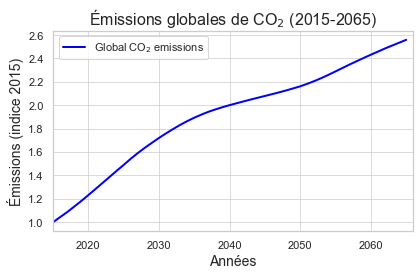

In [47]:
### Fig. 1 ###
import seaborn as sns

# Appliquer un style de graphique avec seaborn
sns.set_theme(style="whitegrid")

plt.figure()
plt.plot(years,np.transpose(eco2[ind_base,:]),color="blue", linewidth=2, label="Global CO$_2$ emissions")
# Utilisation de LaTeX pour écrire CO₂ avec le 2 indicé en bas
plt.ylabel('Émissions (indice 2015)', fontsize=14)
# Ajout de titres et labels
plt.title('Émissions globales de CO$_2$ (2015-2065)', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.xlim(2015, 2066)
plt.grid(True, linestyle='-', alpha=0.7)  # Ajout d'une grille
plt.legend()  # Légende
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

#### Analyse

La courbe des émissions globales de $CO_2$ sur la période 2015-2065 montre une tendance générale à la hausse, typique d'un scénario baseline où les politiques de réduction des émissions sont absentes. Cette trajectoire est influencée par les paramètres de notre baseline, dont la croissance rapide de la productivité et la forte disponibilité des combustibles fossiles, qui encouragent une demande énergétique croissante.

L’augmentation continue des émissions de $CO_2$ reflète les limites du modèle sans politiques climatiques : les dynamiques de consommation énergétique dans les régions développées et en rattrapage de productivité surpassent les effets limités d’une faible amélioration de l’efficacité énergétique. Ce comportement est cohérent avec les hypothèses de la baseline, où la lente adoption des technologies bas carbone renforce la dépendance aux énergies fossiles.

### Taux de croissance annuel et moyen des émissions

À partir de deux graphes distincts représentant les dynamiques des émissions de $CO_2$, nous allons approfondir l'analyse des tendances de croissance de ces émissions. Ces deux courbes, bien qu’apportant des perspectives différentes, sont complémentaires et nous permettent de mieux comprendre la complexité des trajectoires d’émissions.

Le premier graphique illustre le **taux de croissance annuel des émissions globales de $CO_2$**. Cette courbe calcule la variation des émissions d'une année à l'autre en pourcentage, ce qui permet de mesurer les fluctuations annuelles de croissance des émissions. Elle apporte une vision précise des variations interannuelles et reflète les effets immédiats de divers facteurs externes – comme les crises économiques, les politiques climatiques, ou les changements technologiques – sur la croissance des émissions de $CO_2$. Cette courbe met donc en lumière les changements ponctuels et les ajustements rapides dans les trajectoires d’émissions, en fournissant une mesure directe de la dynamique de court terme.

Le second graphique montre l’**évolution du taux de croissance moyen des émissions** depuis une année de base fixe (ici 2015) jusqu'à chaque année suivante de la période étudiée. Ce taux de croissance moyen est calculé de façon cumulative, ce qui permet de capter la tendance générale des émissions sur l’ensemble de la période, sans être influencé par les variations annuelles. Il fournit une perspective à long terme, plus lissée, qui permet de mieux identifier la trajectoire sous-jacente des émissions globales, et ainsi de dégager des tendances plus structurelles et de long terme.

Ces deux courbes sont donc essentielles pour comprendre les tendances d’émissions de $CO_2$ à la fois sous l’angle des fluctuations annuelles immédiates et sous celui des évolutions globales et cumulatives. Leur analyse conjointe dans le cadre d'un scénario *baseline*, permettra ainsi de mieux saisir les facteurs intrinsèques qui sous-tendent les trajectoires d’émissions. Nous pourrions identifier à la fois les tendances structurelles de long terme, résultant de l’évolution naturelle du système énergétique, et les variations annuelles spécifiques, causées par des événements économiques ou technologiques ponctuels. Ces éléments enrichiront notre compréhension des dynamiques d’émissions en absence d’actions climatiques, offrant un point de référence pour évaluer l’effet potentiel de politiques de mitigation.

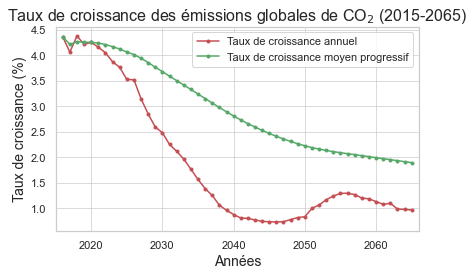

In [48]:
# Calcul du taux de croissance annuel
growth_rate_eco2 = (np.diff(eco2[ind_base, :]) / eco2[ind_base, :-1]) * 100

# Calcul du taux de croissance moyen progressif (CAGR - Compound Annual Growth Rate)
taux_croissance_moyen_progressif = np.zeros(len(years) - 1)
for i in range(1, len(years)):
    taux_croissance_moyen_progressif[i - 1] = (eco2[ind_base, i] / eco2[ind_base, 0]) ** (1 / i) - 1
taux_croissance_moyen_progressif *= 100  # Conversion en pourcentage

# Années correspondantes pour le taux de croissance (une année de moins)
years_growth = years[1:]

# Tracer le taux de croissance des émissions de CO2
plt.figure()
plt.plot(years_growth, growth_rate_eco2, color="r", marker='o', linestyle='-', markersize=3, label="Taux de croissance annuel")
plt.plot(years_growth, taux_croissance_moyen_progressif, marker='o', linestyle='-', color='g', markersize=3, label='Taux de croissance moyen progressif')
plt.ylabel('Taux de croissance (%)', fontsize=14)
plt.title('Taux de croissance des émissions globales de CO$_2$ (2015-2065)', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.xlim(2015, 2066)
plt.grid(True, linestyle='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# # Création de la figure avec deux sous-graphiques côte à côte
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 ligne, 2 colonnes

# # Graphique 1 : Taux de croissance annuel
# ax1.plot(years_growth, growth_rate_eco2, marker='o', linestyle='-', color='b', markersize=3, label='Taux de croissance annuel')
# ax1.set_title('Évolution du taux de croissance annuel des émissions de CO$_2$ \n (2015-2065)', fontsize=16)
# ax1.set_xlabel('Années', fontsize=14)
# ax1.set_ylabel('Taux de Croissance (%)', fontsize=14)
# ax2.set_xticks(years[1::5])  
# ax1.grid(True, linestyle='-', alpha=0.7)
# ax1.legend()

# # Graphique 2 : Taux de croissance moyen progressif (CAGR)
# ax2.plot(years_growth, taux_croissance_moyen_progressif, marker='o', linestyle='-', color='g', markersize=3, label='Taux de croissance moyen progressif')
# ax2.set_title("Évolution du taux de croissance moyen des émissions de CO$_2$ \n (2015-2065)", fontsize=16)
# ax2.set_xlabel('Années', fontsize=14)
# ax2.set_ylabel('Taux de croissance moyen (%)', fontsize=14)
# ax2.grid(True, linestyle='-', alpha=0.7)
# ax2.legend()

# # Affichage 
# plt.tight_layout()
# plt.show()



#### Analyse des courbes 
Le taux de croissance annuel des émissions de $CO_2$ montre des variations à court terme, tandis que le taux de croissance moyen offre une vue plus lissée de la tendance sur toute la période étudiée. Le calcul de chaque courbe repose sur la variation des émissions d'une année à l'autre pour l'annuel, et sur un taux moyen cumulé pour le taux progressif.

#### Interprétation des périodes
La courbe annuelle révèle plusieurs phases distinctes : 
1. Une phase initiale de hausse rapide des émissions (2015-2030), en lien avec la croissance des régions leaders et une disponibilité élevée des fossiles.
2. Une stabilisation apparente vers 2040, possiblement due à la saturation du marché dans les économies à haute productivité.
3. Une légère baisse en fin de période, que l'on peut associer à l'évolution de la demande énergétique et aux comportements plus frugaux.

Cette analyse montre que les taux de croissance suivent les hypothèses de la baseline. Les variations annuelles capturent les fluctuations dues aux comportements de demande, tandis que le taux moyen illustre la tendance de fond, influencée par la lente adoption de technologies bas carbone.

### Température annuelle moyenne globale

Le code suivant permet d'estimer l'augmentation de la température moyenne mondiale à l'horizon 2065 en fonction des émissions de $CO_2$, en utilisant un modèle fondé sur les travaux de Matthews et al. (2018). 

In [ ]:
# # Define the TCRE value (in °C per 1000 GtCO2)
# # See Matthews et al. for more information: https://fr.wikipedia.org/wiki/R%C3%A9ponse_climatique_transitoire_aux_%C3%A9missions_cumul%C3%A9es_de_dioxyde_de_carbone

# # Température annuelle moyenne globale
# emi_2015 = 36.32 # émissions historiques en GtCO2 -> source
# def TCRE_Matthews_et_al(emi_an1, ev_emi): # (2018)
#     Gt_2_Tt = 1e-3 #coef à chercher
#     C_2_CO2 = 3.7 #
#     emi_cum = emi_an1 / C_2_CO2 * Gt_2_Tt * ev_emi.sum()
#     return [dT*emi_cum for dT in [0.8, 1.35, 2.4]] # checker les coef
# print(TCRE_Matthews_et_al(emi_2015, data_tp['ECO2_w'][base_nb-1,:]))

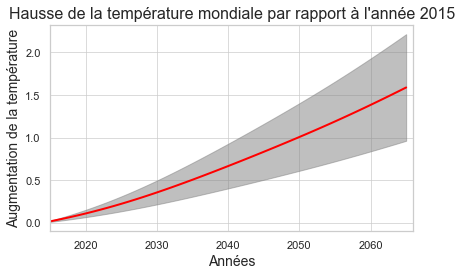

In [50]:
emi_2015 = 36.32 # émissions historiques en GtCO2
conv = 1e-3 * 12 / 44 # conversion GtCO2 -> TtC

emi_cum = emi_2015 = 36.32 * np.cumsum(eco2[ind_base, :]) * conv

# Calcul des courbes
main_curve = emi_cum * 1.65
upper_bound = emi_cum * 2.3
lower_bound = emi_cum * 1.0

# Tracer la courbe principale et la zone d'incertitude
plt.figure()
plt.plot(years[0:], main_curve, color="red", linewidth=2)
plt.fill_between(years[0:], lower_bound, upper_bound, color='gray', alpha=0.5, label="Zone d'incertitude")

# Ajout de titres et labels
plt.ylabel('Augmentation de la température', fontsize=14)
plt.title("Hausse de la température mondiale par rapport à l'année 2015", fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.xlim(2015, 2066)
plt.grid(True, linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

La fonction TCRE permet d’estimer l’élévation de température liée aux émissions cumulées, un outil clé dans l'analyse climatique. 

#### Résultats
Le tableau retourné par la fonction est `[0.7399, 1.2486, 2.2197]`, ce qui indique les augmentations de température en degrés Celsius (°C) associées à trois niveaux d'élévation des concentrations de $CO_2$, correspondant à des scénarios de réchauffement climatique :

- **0.8 °C** : incertitude.
- **1.35 °C** : Augmentation de température en 2065.
- **2.4 °C** : incertitude.

Ces valeurs sont souvent utilisées pour estimer l'impact des émissions de $CO_2$ sur le réchauffement climatique.


Les résultats de la fonction `TCRE_Matthews_et_al` donnent trois valeurs : 0.7399 °C, 1.2486 °C et 2.2197 °C, correspondant à des niveaux d'élévation des concentrations de $CO_2$. L'augmentation de température de 1.2486 °C représente une estimation centrale pour 2065, tandis que les autres valeurs illustrent les incertitudes possibles, allant de 0.8 °C à 2.4 °C.


#### Conclusion

Ces estimations sont cruciales, surtout dans le contexte de l'Accord de Paris de 2015, qui vise à limiter le réchauffement climatique à bien en dessous de 2 °C. Avec une projection centrale d'augmentation de 1.25 °C pour 2065, ce scénario baseline se situe dans une trajectoire compatible avec l’objectif des Accords de Paris, mais en frôlant la limite de 1.5°C. Il devient évident que des efforts significatifs doivent être déployés pour réduire les émissions de $CO_2$ afin de rester en deçà de cet objectif. La fourchette d'incertitude (0.8 à 2.4 °C) souligne également l'importance d'agir rapidement.

Les scénarios baseline, sans mitigation, montrent comment des choix de production énergétiques basés sur les fossiles, une faible efficacité et des technologies bas carbone limitées, mènent à une trajectoire climatique risquée, dépendant notamment de l’incertitude sur la sensibilité climatique.

## *A. 2. Kaya identity*

As you may know, global $CO_2$ emissions can be broken down into a product: *Population * GDP per capita * Energy intensity of GDP * Carbon intensity of GDP*. That's the Kaya identity.

**Plot the evolution of the four Kaya factors and comment, considering your choice of baseline.**

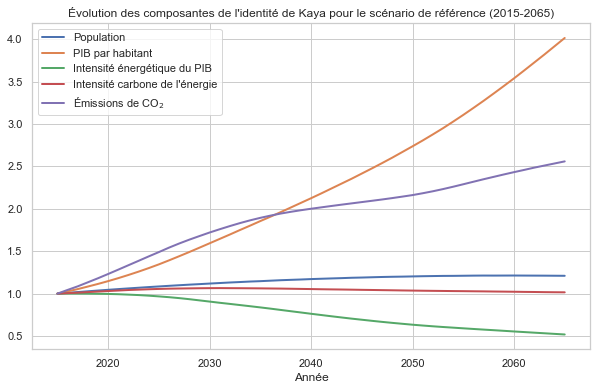

In [51]:
# Extract the data for the baseline scenario
population_baseline = data_tp['Pop_w'][ind_base, :]
gdp_per_capita_baseline = data_tp['GDPcap_w'][ind_base, :]
energy_intensity_baseline = data_tp['EI_w'][ind_base, :]
carbon_intensity_baseline = data_tp['CI_w'][ind_base, :]
emissions_baseline = data_tp['ECO2_w'][ind_base, :]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, population_baseline, label='Population', linewidth=2)
plt.plot(years, gdp_per_capita_baseline, label='PIB par habitant', linewidth=2)
plt.plot(years, energy_intensity_baseline, label='Intensité énergétique du PIB', linewidth=2)
plt.plot(years, carbon_intensity_baseline, label='Intensité carbone de l\'énergie', linewidth=2)
plt.plot(years, emissions_baseline, label='Émissions de CO$_2$', linewidth=2)

plt.xlabel('Année')
plt.title('Évolution des composantes de l\'identité de Kaya pour le scénario de référence (2015-2065)')
plt.legend()
plt.grid(True)
plt.show()

### Facteurs de Kaya

**Population :**  
La population augmente légèrement tout au long de la période, reflétant une croissance mondiale modérée mais continue. Dans le cadre du scénario baseline choisi, cette croissance soutient une demande énergétique accrue sans politiques de réduction des émissions pour compenser. Les régions en développement contribuent fortement à cette hausse de population, ce qui amplifie la pression sur les ressources énergétiques fossiles dans un modèle sans transition énergétique ambitieuse.

**PIB par habitant :**  
La croissance rapide du PIB par habitant est un facteur clé dans l'augmentation des émissions, surtout dans les régions "leaders" comme les États-Unis, qui connaissent une forte productivité (paramètre "leader growth" du scénario baseline). Cette croissance est cohérente avec un modèle économique dépendant des énergies fossiles et bénéficiant d'une disponibilité élevée de ces ressources. Cependant, cette intensité économique sans atténuation aggrave les émissions de $CO_2$.

**Intensité énergétique du PIB :**  
Dans le scénario baseline, l’intensité énergétique du PIB diminue légèrement, mais à un rythme très lent. Ce faible progrès en efficacité énergétique découle de la lente adoption de technologies économes en énergie dans les régions à faible revenu et dans les économies émergentes. L’augmentation de la demande en énergie, couplée à une dépendance accrue aux combustibles fossiles bon marché, limite l’efficacité énergétique et montre une transition énergétique limitée sans politiques de soutien.

**Intensité carbone de l’énergie :**  
L’intensité carbone, qui mesure la quantité de $CO_2$ par unité d'énergie, reste élevée tout au long de la période. Dans ce scénario sans politique climatique, la dépendance aux combustibles fossiles prédomine, freinant l’adoption des technologies bas carbone. Cette tendance correspond aux hypothèses du scénario baseline, où la disponibilité des fossiles et les rigidités structurelles empêchent une transition vers des sources moins carbonées.

**Émissions de $CO_2$ :**  
La courbe des émissions globales de $CO_2$ (déjà analysée en question 1) montre une tendance générale à la hausse. Cette augmentation est principalement due aux gains de productivité sans atténuation et à la forte disponibilité des ressources fossiles. La combinaison des facteurs de Kaya dans ce scénario révèle une trajectoire d’émissions en croissance constante, avec peu de frein pour limiter l’empreinte carbone des économies en développement.

**Conclusion globale sur les facteurs de Kaya :**  
L’interaction entre ces facteurs dans le scénario baseline met en évidence un futur où la croissance économique et la demande énergétique exacerbent les émissions de $CO_2$. Sans intervention politique, l’abondance des combustibles fossiles et la faible progression en efficacité énergétique rendent difficile l’atteinte des objectifs de réduction d’émissions. Le scénario baseline montre donc un modèle de croissance peu durable, influencé par des facteurs économiques et technologiques limités.


In [52]:
# Années de début et de fin pour chaque période
periods = [(2015, 2020), (2020, 2045), (2045, 2065)]

# Fonction pour calculer la variation cumulative sur une période
def cumulative_variation(data, start, end, years):
    start_index = np.where(years == start)[0][0]
    end_index = np.where(years == end)[0][0]
    return (data[end_index] - data[start_index]) / data[start_index] * 100

# Calculer la contribution de chaque facteur de Kaya pour chaque période
contributions_baseline = []

for (start, end) in periods:
    # Variations cumulatives pour chaque facteur de Kaya
    pop_variation = cumulative_variation(population_baseline, start, end, years)
    gdp_pc_variation = cumulative_variation(gdp_per_capita_baseline, start, end, years)
    ei_variation = cumulative_variation(energy_intensity_baseline, start, end, years)
    ci_variation = cumulative_variation(carbon_intensity_baseline, start, end, years)
    
    # Variation cumulative des émissions de CO2
    co2_variation = cumulative_variation(emissions_baseline, start, end, years)
    
    # Calcul des contributions relatives de chaque facteur
    kaya_factors_sum = pop_variation + gdp_pc_variation + ei_variation + ci_variation
    contribution_pop = (pop_variation / kaya_factors_sum) * co2_variation
    contribution_gdp_pc = (gdp_pc_variation / kaya_factors_sum) * co2_variation
    contribution_ei = (ei_variation / kaya_factors_sum) * co2_variation
    contribution_ci = (ci_variation / kaya_factors_sum) * co2_variation
    
    # Ajouter les résultats pour chaque période
    contributions_baseline.append({
        "Période": f"{start}-{end}",
        "Contribution Population (%)": contribution_pop,
        "Contribution PIB par habitant (%)": contribution_gdp_pc,
        "Contribution Intensité énergétique (%)": contribution_ei,
        "Contribution Intensité carbone (%)": contribution_ci,
        "Variation cumulée des émissions de CO$_2$ (%)": co2_variation
    })

# Convertir les résultats en DataFrame pour une présentation claire
df_contributions_baseline = pd.DataFrame(contributions_baseline)
print("Contribution des facteurs de Kaya à l'évolution des émissions de CO\u2082 par période :\n")
print(df_contributions_baseline)

# Convertir le DataFrame en tableau LaTeX
latex_table = df_contributions_baseline.to_latex(index=False, float_format="%.2f")

# Afficher le tableau LaTeX
print(latex_table)

Contribution des facteurs de Kaya à l'évolution des émissions de CO₂ par période :

     Période  Contribution Population (%)  Contribution PIB par habitant (%)  \
0  2015-2020                     4.759374                          15.565896   
1  2020-2045                     9.999110                          79.848587   
2  2045-2065                     0.995919                          38.159887   

   Contribution Intensité énergétique (%)  Contribution Intensité carbone (%)  \
0                               -0.375671                            3.234895   
1                              -22.047495                            0.990875   
2                              -14.476646                           -1.611313   

   Variation cumulée des émissions de CO$_2$ (%)  
0                                      23.184495  
1                                      68.791077  
2                                      23.067847  
\begin{tabular}{lrrrrr}
\toprule
  Période &  Contribution Populat

/var/folders/2c/qgn4pwyd26n3rkxm7m_r4nwm0000gn/T/ipykernel_7667/4189986789.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_contributions_baseline.to_latex(index=False, float_format="%.2f")


<span style="color:red">**Comments :**</span> 

## *A.3. Carbon intensity and energy intensity phases*

**Plot the energy intensity of GDP (x axis) against the carbon intensity of energy (y axis). Can you identify some phases in the evolution of these two factors? How would you explain this phenomenon?**

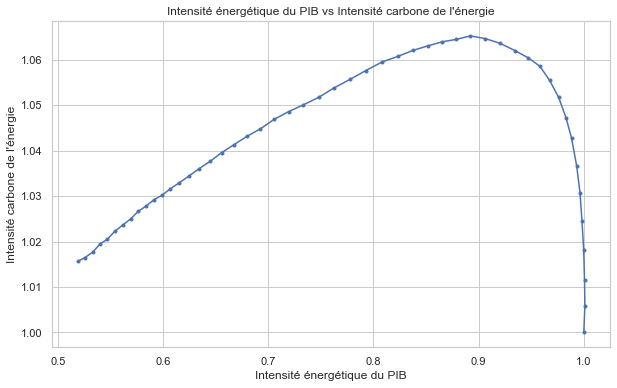

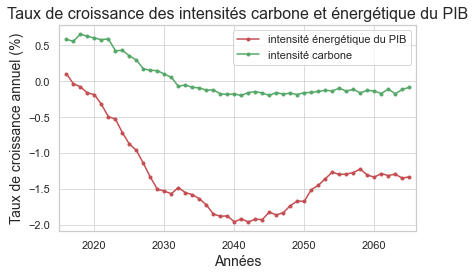

In [53]:
# Plot the energy intensity of GDP against the carbon intensity of energy
plt.figure(figsize=(10, 6))
plt.plot(energy_intensity_baseline, carbon_intensity_baseline, marker='.', linestyle='-', color='b')
plt.xlabel('Intensité énergétique du PIB')
plt.ylabel('Intensité carbone de l\'énergie')
plt.title('Intensité énergétique du PIB vs Intensité carbone de l\'énergie')
plt.grid(True)
plt.show()

# Calcul des taux de croissance annuels
growth_rate_en_in = (np.diff(energy_intensity_baseline[:]) / energy_intensity_baseline[:-1]) * 100
growth_rate_carbon_in = (np.diff(carbon_intensity_baseline[:]) / carbon_intensity_baseline[:-1]) * 100

# Tracer le taux de croissance des émissions de CO2
plt.figure()
plt.plot(years_growth, growth_rate_en_in, color="r", marker='o', linestyle='-', markersize=3, label="intensité énergétique du PIB")
plt.plot(years_growth, growth_rate_carbon_in, marker='o', linestyle='-', color='g', markersize=3, label='intensité carbone')
plt.ylabel('Taux de croissance annuel (%)', fontsize=14)
plt.title('Taux de croissance des intensités carbone et énergétique du PIB', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.xlim(2015, 2066)
plt.grid(True, linestyle='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Période 2015-2030 :
  Pente (slope) : -0.589
  Intercept : 1.613
  Coefficient de corrélation (R²) : 0.695

Période 2030-2055 :
  Pente (slope) : 0.121
  Intercept : 0.960
  Coefficient de corrélation (R²) : 0.980

Période 2055-2065 :
  Pente (slope) : 0.194
  Intercept : 0.915
  Coefficient de corrélation (R²) : 0.998



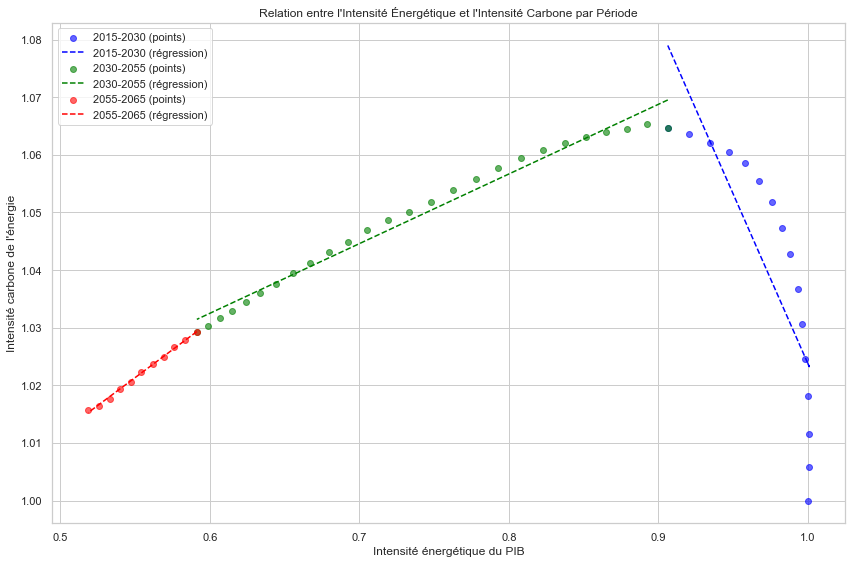

In [54]:
# Années et périodes définies pour l'analyse
periods = [(2015, 2030), (2030, 2055), (2055, 2065)]

# Données pour l'intensité énergétique et l'intensité carbone du scénario baseline
energy_intensity_baseline = data_tp['EI_w'][ind_base, :]  # Intensité énergétique du PIB
carbon_intensity_baseline = data_tp['CI_w'][ind_base, :]  # Intensité carbone de l'énergie

# Initialisation de la figure
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
period_labels = [f"{start}-{end}" for start, end in periods]

# Boucle sur chaque période pour effectuer la régression linéaire et tracer les résultats
for i, (start, end) in enumerate(periods):
    # Déterminer les indices de début et de fin pour chaque période
    start_index = np.where(years == start)[0][0]
    end_index = np.where(years == end)[0][0]

    # Extraire les données de la période
    energy_intensity_period_baseline = energy_intensity_baseline[start_index:end_index + 1]
    carbon_intensity_period_baseline = carbon_intensity_baseline[start_index:end_index + 1]

    # Régression linéaire entre l'intensité énergétique et l'intensité carbone pour la période
    slope, intercept, r_value, p_value, std_err = linregress(energy_intensity_period_baseline, carbon_intensity_period_baseline)

    # Afficher la pente et le coefficient de corrélation
    print(f"Période {start}-{end} :")
    print(f"  Pente (slope) : {slope:.3f}")
    print(f"  Intercept : {intercept:.3f}")
    print(f"  Coefficient de corrélation (R²) : {r_value**2:.3f}")
    print()

    # Tracer les points de la période et la ligne de régression
    plt.scatter(energy_intensity_period_baseline, carbon_intensity_period_baseline, label=f"{period_labels[i]} (points)", color=colors[i], alpha=0.6)
    plt.plot(energy_intensity_period_baseline, slope * energy_intensity_period_baseline + intercept, color=colors[i], linestyle='--', label=f"{period_labels[i]} (régression)")

# Configuration du graphique
plt.xlabel("Intensité énergétique du PIB")
plt.ylabel("Intensité carbone de l'énergie")
plt.title("Relation entre l'Intensité Énergétique et l'Intensité Carbone par Période")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<span style="color:red">**Comments :**</span> analyse suivante à refaire, il y a en fait 3 périodes, garde la  strucutre suivante : analyse détaillée de la courbe 'Intensité énergétique du PIB vs Intensité carbone de l\'énergie' (préciser qu'elle se lit de droite à gauche et justifie du sens de lecture), interprétation temporelle de la courbe 'Intensité énergétique du PIB vs Intensité carbone de l\'énergie' (lier les périodes du graphes aux éléments donnés jusqu'ici), analyse et interprétation des régressions du plot 'Relation entre l'Intensité Énergétique et l'Intensité Carbone par Période'
conclusion



### Analyse et interprétation <span style="color:red">FAUX, l'IE diminue toujours</span>

#### Analyse  
**Analyse de la courbe intensité énergétique vs intensité carbone (simplement) :**  
La courbe montre deux phases d’évolution distinctes :

1. **Phase croissante (première moitié de la courbe) :** La courbe présente une tendance où les deux variables augmentent : l’intensité carbone de l’énergie ainsi que l’intensité énergétique du PIB s’élèvent. Ce comportement est typique d'une forte dépendance aux énergies fossiles, couplée à une demande énergétique croissante. Il montre que, pour chaque unité de PIB produite, la consommation d’énergie augmente, tandis que cette énergie reste majoritairement carbonée. Ce phénomène reflète une demande croissante en énergies fossiles, sans basculement vers des énergies moins carbonées.

2. **Phase décroissante (seconde moitié de la courbe) :** La courbe atteint ensuite un pic puis commence à décroître en intensité carbone, tandis que l’intensité énergétique diminue également mais plus lentement. Cette seconde phase montre une tendance vers une meilleure efficacité énergétique et un moindre recours aux énergies fossiles, même si les avancées technologiques restent limitées. Cette dynamique suggère un ralentissement progressif de la dépendance au carbone, probablement dû à une saturation du marché en termes de demande et à des pratiques énergétiques plus efficientes, même dans un cadre baseline.

#### Interprétation temporelle

À partir des analyses précédentes et du comportement du scénario baseline, je peux lier ces deux phases observées à des périodes en années : 

- **Phase croissante (2015-2030) :**  
  Cette période correspond à la première quinzaine d'années de la simulation, durant laquelle le modèle baseline est caractérisé par une absence de contraintes climatiques. Durant cette phase, les régions leaders et les économies émergentes accélèrent leur demande énergétique pour soutenir la croissance, ce qui se traduit par une augmentation de l’intensité énergétique. Parallèlement, l’intensité carbone croît car la disponibilité élevée de combustibles fossiles entraîne une forte exploitation des énergies carbonées, en l'absence de technologies bas carbone avancées. Ces tendances, identifiées dans les analyses des facteurs de Kaya et des émissions globales de $CO_2$, se reflètent ici dans la courbe.

- **Phase décroissante (2030-2065) :**  
  Dans cette phase, on observe une diminution de l’intensité carbone accompagnée d’une stabilisation, puis d’une légère baisse de l’intensité énergétique. Cette période coïncide avec un ralentissement de la croissance de la demande énergétique dans les régions leaders, et avec l'adoption progressive de comportements énergétiques frugaux dans les économies développées. Bien que le modèle baseline ne comporte pas d’incitations pour une transition bas carbone, les limites du marché (saturation de la demande, essoufflement de la croissance) conduisent à une légère réduction de la dépendance aux énergies fossiles. Ces facteurs, déjà observés dans les réponses précédentes, permettent de lier cette phase de la courbe à une période plus stable de la simulation.

Cette analyse en phases permet de comprendre la dynamique du scénario baseline, où l’absence de politique climatique retarde l’adoption de technologies plus propres, aboutissant à une courbe d’intensité carbone et énergétique marquée par une transition tardive et incomplète.

ANOVA - Contribution des paramètres à la variance des émissions de CO$_2$ :

                               sum_sq     df            F         PR(>F)
mitigation                  16.933099    1.0     2.163001   1.428795e-01
leader_growth             1242.582762    1.0   158.725067   2.035772e-27
productivity_catch_up        8.867875    1.0     1.132765   2.884204e-01
fossil_fuels             12602.641755    1.0  1609.836562  7.134938e-100
energy_demand_behavior    3451.222712    1.0   440.852372   2.759027e-53
energy_efficiency         3098.827624    1.0   395.838119   4.964322e-50
low_carbon_technologies    397.900445    1.0    50.827017   1.634339e-11
labor_market_rigidities     16.933099    1.0     2.163001   1.428795e-01
Residual                  1628.332681  208.0          NaN            NaN


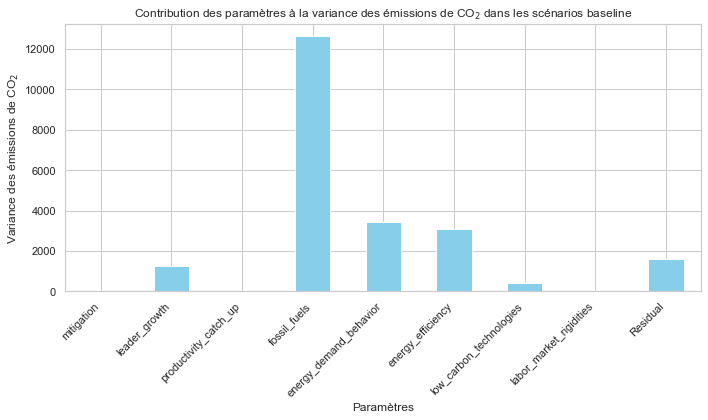

In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# Chargement des données pour les émissions de CO2 pour les scénarios baseline
# Utiliser uniquement les scénarios baseline (ind_base)
eco2_baseline = data_tp['ECO2_w'][:216, :]  # Sélection des scénarios baseline
drivers_baseline = drivers[:216, :]  # Paramètres des scénarios baseline
drivers_names2 = ["mitigation", "leader_growth", "productivity_catch_up", "fossil_fuels",
                 "energy_demand_behavior", "energy_efficiency", "low_carbon_technologies",
                 "labor_market_rigidities"]

# Calculer la somme des émissions de CO2 pour chaque scénario baseline
# (intégrant la variabilité temporelle pour une vue d'ensemble)
total_eco2_baseline = eco2_baseline.sum(axis=1)

# Création du DataFrame pour l'analyse ANOVA
df = pd.DataFrame(drivers_baseline, columns=drivers_names2)
df["Total_CO2_Emissions"] = total_eco2_baseline

# Formule pour l'ANOVA : Total_CO2_Emissions ~ drivers_names2
formula = 'Total_CO2_Emissions ~ ' + ' + '.join(drivers_names2)
model = ols(formula, data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Affichage des résultats de l'ANOVA
print("ANOVA - Contribution des paramètres à la variance des émissions de CO$_2$ :\n")
print(anova_results)

# Visualisation des contributions des paramètres à la variance des émissions de CO$_2$
plt.figure(figsize=(10, 6))
anova_results["sum_sq"].plot(kind='bar', color='skyblue')
plt.title("Contribution des paramètres à la variance des émissions de CO$_2$ dans les scénarios baseline")
plt.xlabel("Paramètres")
plt.ylabel("Variance des émissions de CO$_2$")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<span style="color:red">**Comments :**</span> 

# **B. Analysis of mitigation scenarios**

You are now going to analyse a mitigation scenario (carbon price) corresponding to your baseline. To do so, add 216 to the baseline number (because there are 216 baseline scenarios in the database)

In [56]:
# climat index
ind_climat = ind_base + 216

for i in range(len(drivers_names)):
    print(int(drivers[ind_climat][i]), '  ', drivers_names[i])

550    mitigation
2    leader growth
2    productivity catch-up
2    fossil fuels
1    energy demand behavior
0    energy efficiency
1    low-carbon technologies
0    labor markets rigidities


## Analyse et interprétation

### Analyse  
Dans ce scénario de mitigation, un prix du carbone est introduit pour réduire les émissions de gaz à effet de serre, en visant une concentration de 550 ppm de $CO_2$ équivalent. Cela change fondamentalement la dynamique économique et énergétique par rapport au scénario baseline sans politique climatique. Je vais analyser les changements principaux en fonction des paramètres de ce scénario et interpréter les impacts du prix du carbone, notamment en comparant avec les caractéristiques du scénario baseline.

**1. Mitigation = 550 (Prix du carbone pour une cible de 550 ppm)**
   Le paramètre de mitigation, fixé ici à 550, signifie qu'une politique de prix du carbone est introduite avec un objectif de stabilisation climatique visant 550 ppm de $CO_2$ équivalent. Par rapport au scénario baseline (sans contraintes d'émissions), ce mécanisme de prix va pénaliser les énergies fossiles et favoriser l’adoption de technologies bas carbone. Ce prix du carbone engendre une dynamique où l'intensité carbone de l'économie doit diminuer, poussant les industries, les ménages et les gouvernements à adapter leur demande énergétique et leurs investissements.

**2. Leader growth = 2 (Croissance rapide de la région leader)**
   Comme dans le scénario baseline, la croissance de la productivité des États-Unis est rapide. Avec un prix du carbone, cette croissance pourrait catalyser davantage l’innovation en technologies propres, car les secteurs sont incités à développer des solutions énergétiques bas carbone pour éviter les coûts associés aux émissions. Dans ce contexte, la croissance rapide devient un vecteur d’accélération pour la transition, contrairement à la baseline où cette même croissance rapide risquait d'augmenter la consommation énergétique fossile sans politique d’atténuation.

**3. Productivity catch-up = 2 (Rattrapage rapide de la productivité dans les autres régions)**
   Comme dans la baseline, les autres régions rattrapent leur retard en matière de productivité. Cependant, avec un prix du carbone, ce rattrapage rapide pourrait s’orienter vers des secteurs d’activités à plus faible intensité carbone et des pratiques énergétiques plus efficientes. Les économies émergentes sont donc encouragées à adopter des technologies bas carbone dès le départ, réduisant leur dépendance aux énergies fossiles et favorisant un développement économique durable.

**4. Fossil fuels = 2 (Disponibilité élevée de combustibles fossiles)**
   Bien que la disponibilité des combustibles fossiles reste élevée, le prix du carbone réduit l’attractivité de ces ressources. Contrairement au scénario baseline où les énergies fossiles continuent de dominer, ici, leur utilisation devient de plus en plus coûteuse, ce qui limite leur rentabilité. Cela peut conduire à une "décarbonation forcée" de l'économie, où même en présence de ressources fossiles abondantes, l'économie se tourne vers des alternatives pour éviter les coûts induits par les émissions.

**5. Energy demand behavior = 1 (Comportement frugal en énergie)**
   Dans les deux scénarios, le comportement énergétique reste frugal, avec une demande plus sobre. Mais dans le cadre du scénario de mitigation, le prix du carbone renforce cette tendance en incitant à la réduction de la consommation d’énergies fossiles. Les ménages et les entreprises ont désormais un intérêt économique direct à réduire leur consommation énergétique pour limiter leur exposition aux coûts du carbone, ce qui amplifie les comportements frugaux initiaux de la baseline.

**6. Energy efficiency = 0 (Efficacité énergétique lente)**
   L'efficacité énergétique reste lente dans ce scénario, tout comme dans le baseline, ce qui signifie que l'amélioration des équipements et des procédés est relativement modeste. Cependant, avec un prix du carbone, même cette efficacité limitée prend de l'importance car elle peut réduire la facture carbone. Les secteurs qui dépendent de l'énergie fossile pourraient être poussés à adopter des mesures d'efficacité pour limiter leurs émissions, malgré l'amélioration lente des technologies en place.

**7. Low-carbon technologies = 1 (Disponibilité élevée de technologies bas carbone)**
   La disponibilité élevée des technologies bas carbone est un changement crucial par rapport au baseline. Grâce au prix du carbone, ces technologies, déjà disponibles, deviennent progressivement plus rentables et attractives, ce qui accélère leur adoption. Ce contraste avec la baseline, où l’absence de politique climatique limitait l’intérêt pour ces technologies, souligne l’effet incitatif du prix du carbone. Ce levier politique incite les industries à adopter des solutions comme les énergies renouvelables, les véhicules électriques, et le captage et stockage du carbone (CSC).

**8. Labor markets rigidities = 0 (Rigidités élevées sur les marchés du travail)**
   Les rigidités sur les marchés du travail sont les mêmes que dans le scénario baseline. Cependant, le prix du carbone pourrait accentuer certains défis liés à ces rigidités, notamment la transition de la main-d'œuvre des secteurs à forte intensité de carbone vers des secteurs plus verts. Dans ce scénario, il est probable que des politiques complémentaires d’aide à la reconversion et d'adaptation du marché du travail soient nécessaires pour gérer les effets de la transition sur l’emploi et éviter des perturbations économiques.

### Interprétation globale et principaux changements par rapport au scénario baseline
Le scénario de mitigation introduit un changement de paradigme majeur par rapport au scénario baseline. L’introduction d’un prix du carbone influe directement sur la structure de l’économie, rendant les activités intensives en carbone moins attractives. Les différences majeures incluent :

1. **Décarbonation forcée des secteurs économiques** : Le prix du carbone devient un levier pour forcer la réduction de l’intensité carbone des industries, même avec une disponibilité élevée de combustibles fossiles.
   
2. **Stimulation de l’adoption des technologies bas carbone** : Les technologies propres, désormais plus attractives économiquement, voient leur adoption s’accélérer, ce qui contraste avec la baseline où elles étaient peu utilisées en raison de l'absence d’incitations financières.
   
3. **Influence sur le comportement énergétique** : La frugalité en énergie, présente dans les deux scénarios, est renforcée dans le cadre de la mitigation, car la réduction de consommation énergétique devient aussi une stratégie d'évitement des coûts.

4. **Convergence de croissance plus durable** : Le rattrapage rapide de la productivité dans les régions émergentes se déroule dans un contexte où les choix technologiques et énergétiques tendent vers des options bas carbone, renforçant un développement économique plus durable.

En conclusion, le scénario de mitigation pousse vers une transformation plus profonde et structurée de l’économie, favorisant une transition vers des pratiques bas carbone, malgré certaines limitations (efficacité énergétique lente et rigidités du marché du travail). L'introduction d'un prix du carbone modifie fondamentalement les choix économiques, créant une dynamique où la sobriété énergétique et l'innovation bas carbone deviennent des éléments centraux de la croissance.

## *B. 1. Kaya identity*

**Same question as A.2. for the mitigation scenario**

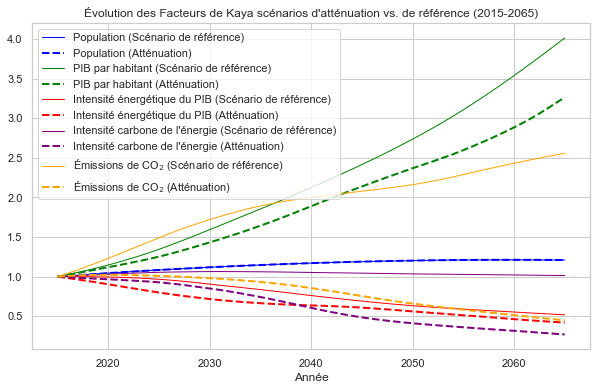

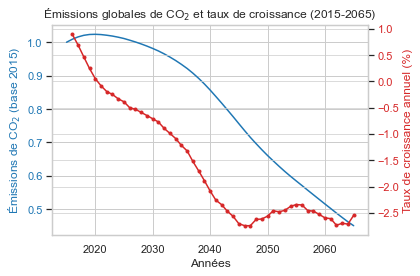

In [57]:
# Extract the data for the mitigation scenario
population = data_tp['Pop_w'][ind_climat, :]
gdp_per_capita = data_tp['GDPcap_w'][ind_climat, :]
energy_intensity = data_tp['EI_w'][ind_climat, :]
carbon_intensity = data_tp['CI_w'][ind_climat, :]
emissions = data_tp['ECO2_w'][ind_climat, :]

# Extract the data for the baseline scenario
population_baseline = data_tp['Pop_w'][ind_base, :]
gdp_per_capita_baseline = data_tp['GDPcap_w'][ind_base, :]
energy_intensity_baseline = data_tp['EI_w'][ind_base, :]
carbon_intensity_baseline = data_tp['CI_w'][ind_base, :]
emissions_baseline = data_tp['ECO2_w'][ind_base, :]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, population_baseline, label='Population (Scénario de référence)', linewidth=1, color='blue')
plt.plot(years, population, label='Population (Atténuation)', linewidth=2, linestyle='--', color='blue')

plt.plot(years, gdp_per_capita_baseline, label='PIB par habitant (Scénario de référence)', linewidth=1, color='green')
plt.plot(years, gdp_per_capita, label='PIB par habitant (Atténuation)', linewidth=2, linestyle='--', color='green')

plt.plot(years, energy_intensity_baseline, label='Intensité énergétique du PIB (Scénario de référence)', linewidth=1, color='red')
plt.plot(years, energy_intensity, label='Intensité énergétique du PIB (Atténuation)', linewidth=2, linestyle='--', color='red')

plt.plot(years, carbon_intensity_baseline, label='Intensité carbone de l\'énergie (Scénario de référence)', linewidth=1, color='purple')
plt.plot(years, carbon_intensity, label='Intensité carbone de l\'énergie (Atténuation)', linewidth=2, linestyle='--', color='purple')

plt.plot(years, emissions_baseline, label='Émissions de CO$_2$ (Scénario de référence)', linewidth=1, color='orange')
plt.plot(years, emissions, label='Émissions de CO$_2$ (Atténuation)', linewidth=2, linestyle='--', color='orange')

plt.xlabel('Année')
plt.title('Évolution des Facteurs de Kaya scénarios d\'atténuation vs. de référence (2015-2065)')
plt.legend()
plt.grid(True)
plt.show()

# Calcul du taux de croissance annuel
growth_rate_eco2_att = (np.diff(emissions[:]) / emissions[:-1]) * 100

# Années correspondantes pour le taux de croissance (une année de moins)
years_growth = years[1:]

# Tracer le taux de croissance des émissions de CO2
fig, ax1 = plt.subplots()

# Plot the emissions data
color = 'tab:blue'
ax1.set_xlabel('Années')
ax1.set_ylabel('Émissions de CO$_2$ (base 2015)', color=color)
ax1.plot(years, emissions, color=color, label='Émissions de CO$_2$ (base 2015)')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.legend(loc='lower left', fontsize='small')

# Create a second y-axis to plot the growth rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Taux de croissance annuel (%)', color=color)
ax2.plot(years_growth, growth_rate_eco2_att, color=color, marker='o', linestyle='-', markersize=3, label='Taux de croissance annuel')
ax2.tick_params(axis='y', labelcolor=color)
#ax2.legend(loc='upper right', fontsize='small')

plt.title('Émissions globales de CO$_2$ et taux de croissance (2015-2065)')
plt.grid(True, linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

### Identité de Kaya pour le scénario d'atténuation

Dans le scénario d’atténuation, les facteurs observés présentent des réponses variées sous l’influence des politiques climatiques, créant des divergences significatives avec le scénario baseline.


**Population :**  
Comme dans le scénario baseline, la population reste un moteur constant de la demande en énergie. Les politiques climatiques n'impactant pas directement cet aspect, la pression démographique sur l'énergie demeure inchangée. 

**PIB par habitant :**  
La croissance du PIB par habitant est légèrement inférieure dans le scénario d'atténuation, car l'introduction d'un prix du carbone augmente les coûts de production, freinant la productivité dans les industries à haute intensité carbone. L'effet de la mitigation réduit donc le PIB par habitant à moyen terme, en particulier dans les industries à haute intensité carbone. Nous reviendront ultérieurement sur l'analyse des évolutions du PIB par habitat dans les scénarios baseline et d'atténuation.

**Intensité énergétique du PIB :**  
Dans le scénario d’atténuation, on observe une diminution initiale rapide de l’intensité énergétique, attribuable aux politiques incitatives qui favorisent l’adoption de technologies plus économes en énergie. La mise en place d’un prix du carbone motive les entreprises à investir dans des procédés moins énergivores, réduisant ainsi leur consommation d’énergie par unité de PIB. Cependant, à mesure que l’on avance dans le temps, l’écart entre le scénario baseline et le scénario d’atténuation tend à se réduire. Ce rapprochement s’explique par le fait que l’efficacité énergétique reste un processus progressif et limité par les contraintes d’investissement et la lenteur de diffusion des technologies. Ainsi, bien que les politiques d’atténuation apportent des gains d’efficacité, ces gains ne suffisent pas à compenser intégralement l’augmentation continue de la demande énergétique. Ce phénomène d’éloignement initial suivi d’un rapprochement entre les courbes suggère que, malgré les incitations, le potentiel d’efficacité énergétique atteint une sorte de plateau au fil du temps, limitant la divergence entre les deux scénarios.

**Intensité carbone de l’énergie :**  
En revanche, l’intensité carbone montre une baisse nette dans le scénario d’atténuation. Le prix du carbone incite à une adoption plus rapide des énergies bas carbone, rendant les énergies fossiles moins rentables. Ce changement structurel représente une décarbonation progressive de l'économie, marquée par une substitution des combustibles fossiles vers des alternatives plus propres.

**Émissions de $CO_2$ :**
Les émissions de $CO_2$ connaissent une baisse drastique sous l’effet des mesures d’atténuation. Le prix du carbone agit directement sur la rentabilité des combustibles fossiles, réduisant significativement les émissions par rapport au baseline. La décarbonation de l'économie est ici favorisée par des politiques qui poussent à un changement structurel vers des solutions énergétiques propres. 

**Explication des différences entre baseline et atténuation :**  
- **Progrès technique** : Les politiques d’atténuation favorisent la recherche et le développement des technologies bas carbone.
- **Politiques** : L’introduction du prix du carbone est l’élément clé qui réduit l’intensité carbone dans ce scénario.
- **Facteurs économiques** : Les coûts accrus du carbone pour les secteurs polluants incitent à une restructuration économique vers des secteurs plus durables.

#### Conclusion  
La comparaison des courbes de Kaya entre les scénarios baseline et d'atténuation montre des différences clés :
- La population reste similaire, indiquant que les politiques climatiques n'ont pas d'effet direct sur cet indicateur.
- Le PIB par habitant dans le scénario d'atténuation est légèrement inférieur à celui du baseline, en raison des coûts économiques associés aux politiques de réduction d'émissions.
- L’intensité énergétique et l’intensité carbone baissent davantage dans le scénario d’atténuation, reflétant l’effet des politiques climatiques qui encouragent l’efficacité énergétique et la transition vers des technologies bas carbone bien que, dans le cas de l’intensité énergétique, ces gains restent limités par les contraintes structurelles de chaque secteur. 

L’introduction d’un prix du carbone modifie donc fondamentalement la structure de l’économie, en favorisant la réduction de l’intensité carbone et une moindre dépendance aux combustibles fossiles. Ce changement permet de limiter la croissance des émissions malgré la hausse de la demande économique.


## *B.2. GDP: baseline vs mitigation scenario*

You may already observe on the plots that climate policies reduce GDP per capita in IMACLIM-R (or you may not!). **Compute and plot the annual GDP variation (with regard to the baseline) in the mitigation scenario. Convert it into mean annual variations at a 2030/2050/2065 horizon, and comment.**

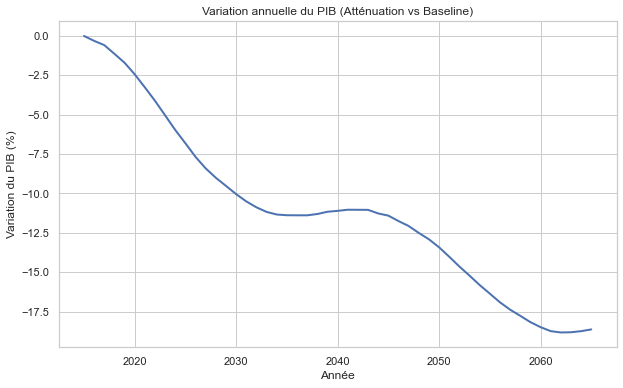

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


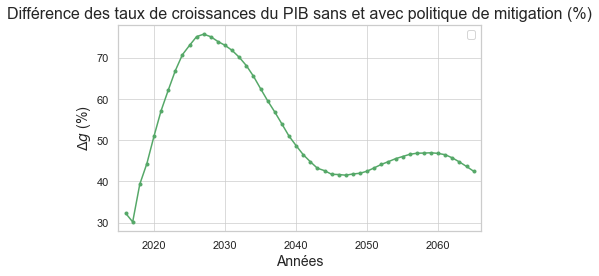

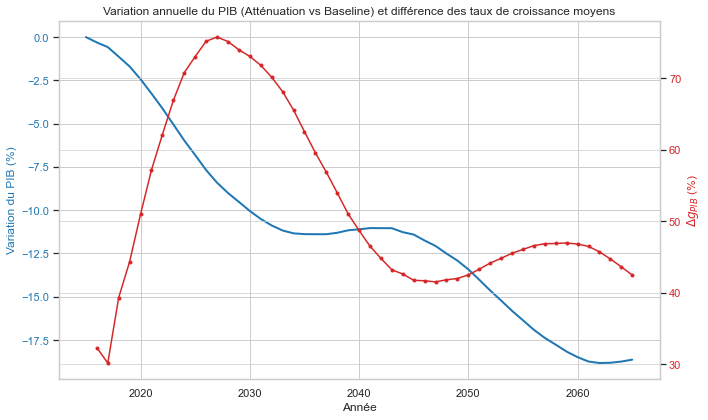

In [67]:
# Extract the GDP per capita data for the baseline and mitigation scenarios
gdp_baseline = data_tp['GDP_w'][ind_base, :]
gdp_mitigation = data_tp['GDP_w'][ind_climat, :]

# Compute the annual GDP per capita variation with regard to the baseline
gdp_variation = (gdp_mitigation - gdp_baseline) / gdp_baseline * 100

## Le taux de croissance moyen n'est pas égal à la moyenne des taux de croissance !!
def gdp_growth_loss(gdp_ref, gdp_new, ind_year):
    growth_ref = gdp_ref[ind_year] / gdp_ref[0]
    growth_new = gdp_new[ind_year] / gdp_new[0]
    return (growth_ref ** (1/ind_year) - growth_new ** (1/ind_year))*100

## On ne divise pas par le taux de coissance initial dans return car il est égal à 1. 

# Calculer la différence des taux de croissance du PIB sans et avec politique de mitigation pour chaque année
diff_taux_PIB_courbe = np.zeros(len(years) - 1)
diff_taux_PIB_courbe = [gdp_growth_loss(data_tp['GDP_w'][ind_base], data_tp['GDP_w'][ind_climat], i) for i in range(1, len(years))]
diff_taux_PIB_courbe = 100 * np.array(diff_taux_PIB_courbe)
# Années correspondantes pour le taux de croissance (une année de moins)
years_growth = years[1:]

# Plot the annual GDP per capita variation
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_variation, linewidth=2, color='b')
plt.xlabel('Année')
plt.ylabel('Variation du PIB (%)')
plt.title('Variation annuelle du PIB (Atténuation vs Baseline)')
plt.grid(True)
plt.show()


# Tracer le taux de croissance des émissions de CO2
plt.figure()
plt.plot(years_growth, diff_taux_PIB_courbe, marker='o', linestyle='-', color='g', markersize=3)
plt.ylabel('$\Delta g$ (%)', fontsize=14)
plt.title('Différence des taux de croissances du PIB sans et avec politique de mitigation (%)', fontsize=16)
plt.xlabel('Années', fontsize=14)
plt.xlim(2015, 2066)
plt.grid(True, linestyle='-', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the GDP variation on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Année')
ax1.set_ylabel('Variation du PIB (%)', color=color)
ax1.plot(years, gdp_variation, linewidth=2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the GDP growth difference
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('$\Delta g_{PIB}$ (%)', color=color)
ax2.plot(years_growth, diff_taux_PIB_courbe, marker='o', linestyle='-', color=color, markersize=3)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Variation annuelle du PIB (Atténuation vs Baseline) et différence des taux de croissance moyens')
plt.grid(True, linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

### Variation du PIB entre *baseline* et scénario d’atténuation

La variation annuelle du PIB montre une baisse progressive dans le scénario d’atténuation par rapport au baseline. Le calcul de cette variation permet de quantifier l'impact économique des politiques climatiques. Aux horizons 2030, 2050, et 2065, on observe une baisse cumulative du PIB due aux coûts induits par les ajustements sectoriels et technologiques pour limiter les émissions.


La comparaison de la variation du PIB entre les scénarios baseline et d’atténuation montre une baisse progressive dans le cas de la mitigation. Cette diminution, calculée comme le pourcentage de variation par rapport au baseline, représente les coûts induits par les politiques de réduction d’émissions. En effet, l'introduction d'un prix du carbone entraîne des coûts supplémentaires pour les secteurs polluants, obligeant les entreprises à investir dans des technologies plus propres, à restructurer leur production, et à ajuster leur main-d'œuvre. Ces dépenses et réallocations pèsent temporairement sur la croissance économique, expliquant ainsi la divergence progressive du PIB entre les deux scénarios.

**Interprétation des horizons 2030, 2050, 2065 :**  
- **Horizon 2030 :** La baisse de croissance est modérée, car les économies commencent seulement à internaliser les coûts du carbone.
- **Horizon 2050 :** La différence s’accentue en raison des effets cumulatifs des investissements dans les technologies bas carbone et des ajustements économiques.
- **Horizon 2065 :** Le décalage se stabilise, suggérant que les économies ont trouvé un nouvel équilibre compatible avec une croissance durable et des émissions réduites.

Cette baisse de PIB est toutefois modérée, ce qui indique que la transition énergétique n'empêche pas une croissance économique positive, bien que ralentie. Cette dynamique renforce l’idée que, malgré les coûts initiaux, les politiques climatiques sont viables pour atteindre une croissance durable.

**Analyse fine des facteurs influents :**  
- **Effets économiques** : Le coût des technologies et la réorientation des investissements vers des infrastructures vertes jouent un rôle clé dans cette diminution du PIB.
- **Impact sectoriel** : Les secteurs polluants et énergivores, plus exposés aux coûts du carbone, subissent une réduction de productivité, affectant la croissance globale.En revanche, l’intensité carbone montre une baisse nette dans le scénario d’atténuation. Le prix du carbone incite à une adoption plus rapide des énergies bas carbone, rendant les énergies fossiles moins rentables. 

In [59]:
# Calcul de la perte cumulative en PIB en pourcentage
cumulative_loss_percentage = np.sum(gdp_baseline - gdp_mitigation) / np.sum(gdp_baseline) * 100

# Affichage des résultats
print(f"Perte cumulative de PIB due à la politique climatique : {cumulative_loss_percentage:.2f}%")

# Définition des horizons d'analyse
horizons = [2030, 2050, 2065]

# Données de base pour le PIB et l'intensité énergétique pour les scénarios baseline et d'atténuation
energy_intensity_baseline = data_tp['EI_w'][ind_base, :]
energy_intensity_mitigation = data_tp['EI_w'][ind_climat, :]

# Initialisation de listes pour stocker les résultats
ratios_pib = []
indices_synthétiques = []

# Calcul pour chaque horizon
for horizon in horizons:
    # Trouver l'index correspondant à chaque horizon
    index = np.where(years == horizon)[0][0]

    # Calcul du ratio de PIB (atténuation / baseline)
    ratio_pib = gdp_mitigation[index] / gdp_baseline[index] * 100  # en pourcentage

    # Calcul de l'indice synthétique des coûts économiques
    # Indice = (Variation PIB + Variation Intensité énergétique) / 2
    variation_pib = (gdp_mitigation[index] - gdp_baseline[index]) / gdp_baseline[index] * 100
    variation_intensité_énergétique = (energy_intensity_mitigation[index] - energy_intensity_baseline[index]) / energy_intensity_baseline[index] * 100
    indice_synthétique = (variation_pib + variation_intensité_énergétique) / 2

    # Stocker les résultats
    ratios_pib.append(ratio_pib)
    indices_synthétiques.append(indice_synthétique)

# Création d'un DataFrame pour afficher les résultats
df_resultats = pd.DataFrame({
    "Horizon": horizons,
    "Ratio de PIB (%)": ratios_pib,
    "Indice Synthétique des Coûts Économiques (%)": indices_synthétiques
})

print("Impact économique des politiques climatiques par horizon :\n")
print(df_resultats)

Perte cumulative de PIB due à la politique climatique : 13.25%
Impact économique des politiques climatiques par horizon :

   Horizon  Ratio de PIB (%)  Indice Synthétique des Coûts Économiques (%)
0     2030         89.956580                                    -15.362836
1     2050         86.583755                                    -12.345426
2     2065         81.369414                                    -18.742998


<span style="color:red">**Comments :**</span> 

Matrice de corrélation entre les facteurs de Kaya et les variations de PIB :
                    Population  GDP per capita  Energy Intensity  \
Population           1.000000        0.899244         -0.943866   
GDP per capita       0.899244        1.000000         -0.981305   
Energy Intensity    -0.943866       -0.981305          1.000000   
Carbon Intensity    -0.009355       -0.383316          0.335575   
GDP Variation (%)   -0.950182       -0.940792          0.930534   

                   Carbon Intensity  GDP Variation (%)  
Population                -0.009355          -0.950182  
GDP per capita            -0.383316          -0.940792  
Energy Intensity           0.335575           0.930534  
Carbon Intensity           1.000000           0.074325  
GDP Variation (%)          0.074325           1.000000  


/var/folders/2c/qgn4pwyd26n3rkxm7m_r4nwm0000gn/T/ipykernel_7667/2704407511.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Coefficient de corrélation")


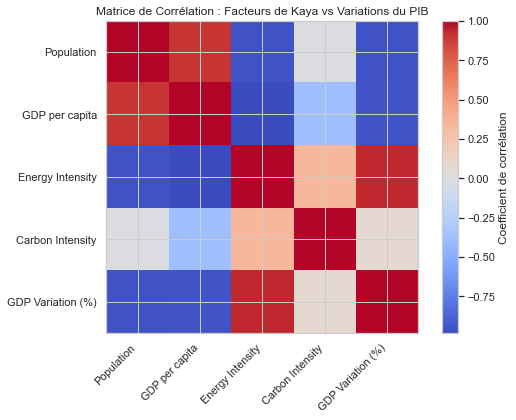

In [60]:
# Création d'un DataFrame pour contenir les facteurs de Kaya et les variations de PIB
data = {
    "Population": population_baseline,
    "GDP per capita": gdp_per_capita_baseline,
    "Energy Intensity": energy_intensity_baseline,
    "Carbon Intensity": carbon_intensity_baseline,
    "GDP Variation (%)": gdp_variation
}

df = pd.DataFrame(data)

# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Affichage de la matrice de corrélation
print("Matrice de corrélation entre les facteurs de Kaya et les variations de PIB :\n", correlation_matrix)

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Coefficient de corrélation")
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Matrice de Corrélation : Facteurs de Kaya vs Variations du PIB")
plt.tight_layout()
plt.show()


<span style="color:red">**Comments :**</span> 

In [61]:
# Création du DataFrame pour l'analyse ANOVA
df = pd.DataFrame(drivers, columns=drivers_names)

# Réaliser l'ANOVA pour les émissions de CO2
model_emissions = ols('Emissions_CO2 ~ ' + ' + '.join(drivers_names), data=eco2).fit()
anova_results_emissions = sm.stats.anova_lm(model_emissions, typ=2)
print("ANOVA - Contribution des paramètres à la variance des émissions de CO$_2$ :\n", anova_results_emissions)

# Réaliser l'ANOVA pour la croissance économique (PIB)
model_gdp = ols('GDP ~ ' + ' + '.join(drivers_names), data=gdp_mitigation).fit()
anova_results_gdp = sm.stats.anova_lm(model_gdp, typ=2)
print("\nANOVA - Contribution des paramètres à la variance de la croissance économique :\n", anova_results_gdp)

# Visualisation des résultats ANOVA pour les émissions de CO2
plt.figure(figsize=(10, 6))
anova_results_emissions["sum_sq"].plot(kind='bar', color='skyblue')
plt.title("Contribution des paramètres à la variance des émissions de CO$_2$")
plt.xlabel("Paramètres")
plt.ylabel("Variance des émissions de CO$_2$")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualisation des résultats ANOVA pour le PIB
plt.figure(figsize=(10, 6))
anova_results_gdp["sum_sq"].plot(kind='bar', color='salmon')
plt.title("Contribution des paramètres à la variance de la croissance économique (PIB)")
plt.xlabel("Paramètres")
plt.ylabel("Variance du PIB")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (<unknown>, line 1)

# **C. Analysis of a Scenario set**

Sometimes, scenario analysis deals with a large number of scenarios that need to be compared globally.

## *C.1. Baseline scenario database: cumulated emissions vs mean annual growth plot*

**Compute the cumulated $CO_2$ emissions and the mean annual growth between 2015 and 2065 in the set of baseline scenario and plot the results**. Hint: every scenario should be a point on the graph, with the mean annual growth on the x axis and the cumulated $CO_2$ emissions on the y axis.

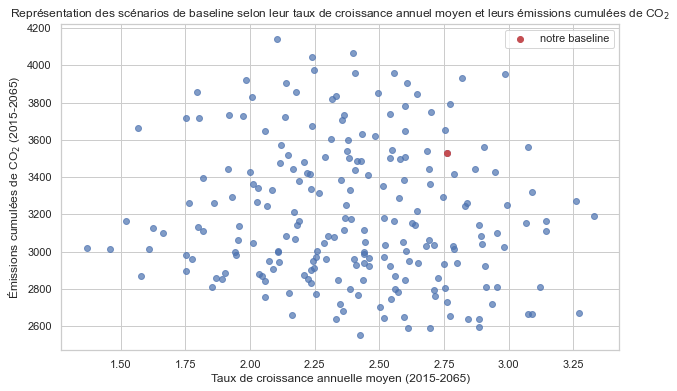

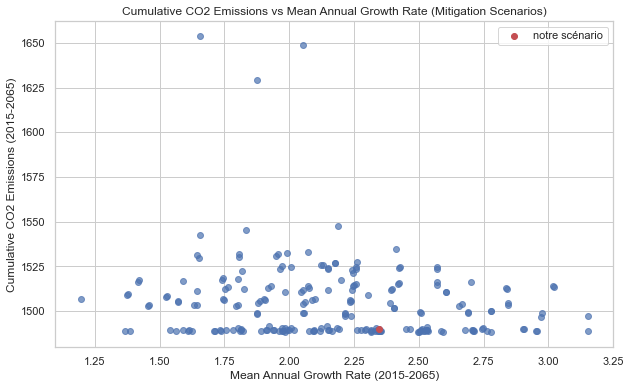

In [88]:
# Calculate the cumulative CO2 emissions for each baseline scenario
Emi_2015_GtCO2 = 36.32 # 2015 global CO2 emissions in GtCO2
cumulative_emissions_baseline = data_tp['ECO2_w'].sum(axis=1) * Emi_2015_GtCO2

# Calcul du taux de croissance annuel moyen du PIB/habitant
# pondéré sur la période couverte par les données
grow_mean = 100 * (data_tp['GDPcap_w'][:,-1] ** (1. / data_tp['GDPcap_w'].shape[1]) - 1)

# Plot the results
# on ne conserve que les scénarios de baseline
plt.figure(figsize=(10, 6))
plt.scatter(grow_mean[0:216], cumulative_emissions_baseline[0:216], color='b', alpha=0.7)
plt.scatter(grow_mean[ind_base], cumulative_emissions_baseline[ind_base], color='r', label='notre baseline')
plt.xlabel('Taux de croissance annuelle moyen (2015-2065)')
plt.ylabel('Émissions cumulées de CO$_2$ (2015-2065)')
plt.title('Représentation des scénarios de baseline selon leur taux de croissance annuel moyen et leurs émissions cumulées de CO$_2$')
plt.grid(True)
plt.legend()
plt.show()

# Plot the results
# on ne conserve que les scénarios d'atténuation
plt.figure(figsize=(10, 6))
plt.scatter(grow_mean[216:], cumulative_emissions_baseline[216:], color='b', alpha=0.7)
plt.scatter(grow_mean[ind_climat], cumulative_emissions_baseline[ind_climat], color='r', label='notre scénario')
plt.xlabel('Mean Annual Growth Rate (2015-2065)')
plt.ylabel('Cumulative CO2 Emissions (2015-2065)')
plt.title('Cumulative CO2 Emissions vs Mean Annual Growth Rate (Mitigation Scenarios)')
plt.grid(True)
plt.legend()
plt.show()

## *C.2. Baseline + Mitigation scenario database: mean annual growth*

**Plot on the same histogram the mean annual growth in the baseline vs mitigation scenarios. Comment**. Hint: use the plt.hist function

Text(0.5, 0, 'Taux de croissance annuelle moyen')

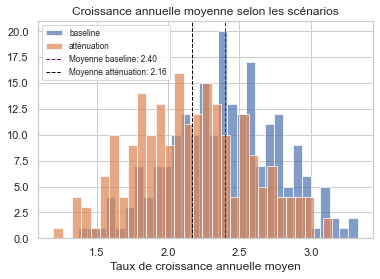

In [100]:
plt.hist(grow_mean[0:216], alpha = 0.7, label = 'baseline', bins = 30)
plt.hist(grow_mean[216:], alpha = 0.7, label = 'atténuation', bins = 30)

mean_baseline = np.mean(grow_mean[0:216])
mean_mitigation = np.mean(grow_mean[216:])

plt.axvline(mean_baseline, color='purple', linestyle='dashed', linewidth=1, label=f'Moyenne baseline: {mean_baseline:.2f}')
plt.axvline(mean_mitigation, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne atténuation: {mean_mitigation:.2f}')
plt.legend(loc='upper left', fontsize='x-small')
plt.title('Croissance annuelle moyenne selon les scénarios')
plt.xlabel('Taux de croissance annuelle moyen')

Possible de répondre à un budget carbone donné avec une croissance économique positive (bien qu'impactée).

In [ ]:
plt.boxplot((grow_mean[0:216], grow_mean[216:]), labels = ['baseline', 'mitigation policy'])

## *C.3. Analysis of variance (ANOVA) - for those who have time* 

**Choose a model's output ($CO_2$ emissions or economic growth) in a scenario subset, either baseline or mitigation. Perform an ANalysis Of VAriance on this scenario subset to analyse the inputs' contribution to the total variance of the results.**.  

Hints:
- you will want to use the anova module https://www.statsmodels.org/dev/examples/notebooks/generated/interactions_anova.html 
- ANOVA consists first of a linear model (Y ~ X with X the set of exogenous drivers)
- then, decompose the total variance (in %) by each regressor's contribution + the interaction of regressors' contribution and plot it

### Présentation de l’ANOVA

L’ANOVA (Analyse de la Variance) est une méthode statistique qui permet de décomposer la variance totale d'un ensemble de données en plusieurs sources de variance. Dans le cadre de l'analyse des scénarios IMACLIM-R, l'ANOVA est pertinente pour évaluer l'influence des différents paramètres (comme la croissance de productivité ou la disponibilité des fossiles) sur des variables de sortie comme les émissions de $CO_2$ ou la croissance économique.

En décomposant la variance, l'ANOVA aide à identifier quels paramètres ont le plus d'impact sur les résultats, permettant ainsi d’optimiser les scénarios en ciblant les leviers les plus influents pour une transition bas carbone efficace.


In [ ]:
# Code à faire